In [76]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import add0



In [77]:
def clean_dir(path):
    paths_to_remove = []
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

def clean_temp(path):
    Lpaths = get_model_paths(10, 'true-init')
    results = {}
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2
        if 'support' not in list(cfg.model.keys()):
            print(cfg)
            # shutil.rmtree(path)
            print('Removing old experiment')
        # print(obs_var)
        # print(cfg)

        # res = pickle_open(os.path.join(path, 'res.pickle'))
        # res['cfg'] = cfg
        # results[obs_var] = res

In [48]:
def load_results(paths, **kwargs):
    Lpaths = get_model_paths(paths, **kwargs)
    results = {}
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        obs_var = cfg.obs.ov2

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results[obs_var] = res
    return results

def get_model_paths(paths, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if cfg.latent.L == L:
                if cfg.model.emiters == emiters:
                    if cfg.model.init == init:
                        if supp is not None:
                            if 'support' in list(cfg.model.keys()):
                                if cfg.model.support == supp:
                                        sel_paths.append(exp)
                        else:
                            if 'support' not in list(cfg.model.keys()):
                                if cfg.model.emiters == emiters:
                                    sel_paths.append(exp)
                            else:
                                if cfg.model.support == supp:
                                        sel_paths.append(exp)
    return sel_paths

In [49]:
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/outputs/2024-07-29', 
             '/projectnb/stephenlab/jtauber/cohlib/hydra/outputs/2024-07-30']

In [78]:
clean_dir[res_paths[1]]

TypeError: 'function' object is not subscriptable

In [50]:
from cohlib.utils import gamma_root
def compute_naive_and_oracle(cfg):
    lcfg = cfg.latent
    ocfg = cfg.obs

    gamma_path = os.path.join(gamma_root(), f"{cfg.latent.gamma}.pickle")
    gamma_load = pickle_open(gamma_path)
    gamma_full = gamma_load['gamma']
    freqs = gamma_load['freqs']
    N = freqs.size
    nz = gamma_load['nonzero_inds']
    K = gamma_full.shape[-1]

    gamma_full *= lcfg.scale

    lrk = jr.key(lcfg.seed)
    zs = sample_from_gamma(lrk, gamma_full, lcfg.L)
    gamma_est_oracle = jnp.einsum('nkl,nil->nkil', zs, zs.conj()).mean(-1)



    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(ocfg.seed)


    obs_var = ocfg.ov1 * 10**ocfg.ov2
    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    obs_mc = obs - obs.mean(0)[None,:,:]
    obs_f = jnp.fft.rfft(obs_mc, axis=0)[1:,:,:]
    gamma_est_naive = jnp.einsum('nkl,nil->nkil', obs_f, obs_f.conj()).mean(-1)

    return gamma_est_oracle, gamma_est_naive

In [88]:
def pow(gamma, k, db=False, freq_inds=None):
    if freq_inds is None:
        freq_inds = jnp.arange(gamma.shape[0])
    S = gamma[freq_inds,k,k].real
    if db is True:
        S = 10*jnp.log10(S+1e-15)
    return S

def plot_result_allfreqs(ax, res_fit50, res_single, db, fshow, k=0, leg=False, show_naive=True):
    gamma_oracle, gamma_naive = compute_naive_and_oracle(res_fit50['cfg'])

    fit50_nz = res_fit50['gamma']
    fit50 = jnp.zeros_like(gamma_true)
    gamma_model_fit50 = fit50.at[nz_fit50,:,:].set(fit50_nz)

    single_nz = res_single['gamma']
    single = jnp.zeros_like(gamma_true)
    gamma_model_single = single.at[nz,:,:].set(single_nz)


    S_true = pow(gamma_true, k, db, fshow)
    S_oracle = pow(gamma_oracle, k, db, fshow)
    S_naive = pow(gamma_naive, k, db, fshow)
    S_model_fit50 = pow(gamma_model_fit50, k, db, fshow)
    S_model_single = pow(gamma_model_single, k, db, fshow)


    ax.plot(S_true, 'k', linewidth=2, label='True')
    ax.plot(S_oracle, 'tab:grey', label='Oracle')
    if show_naive:
        ax.plot(S_naive, 'tab:red', label='Naive')
    ax.plot(S_model_fit50, 'tab:blue', label='Model')
    if leg == True:
        ax.legend()
    # ax.plot(S_model_single, 'tab:green', label='Model')

In [52]:
gamma_name = 'k2-single-10'
gamma_path = os.path.join(gamma_root(), f"{gamma_name}.pickle")
gamma_load = pickle_open(gamma_path)
gamma_raw = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']

In [68]:
supp_full = [0, 50]
nz_fit50 = jnp.where((freqs >= supp_full[0]) & (freqs <= supp_full[1]))

L = 50
init = 'true-init'
emiters = 20

supp = [0, 50]
res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
supp = None
res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)

scale = res_single[0]['cfg'].latent.scale
gamma_true = gamma_raw*scale

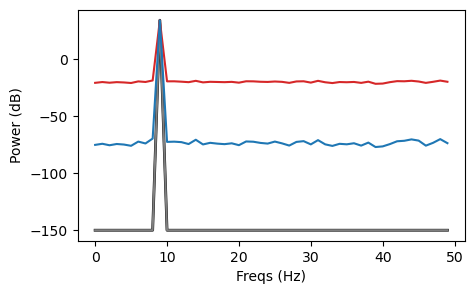

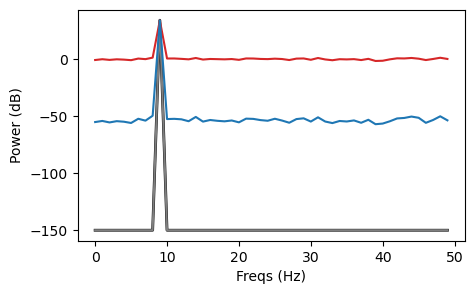

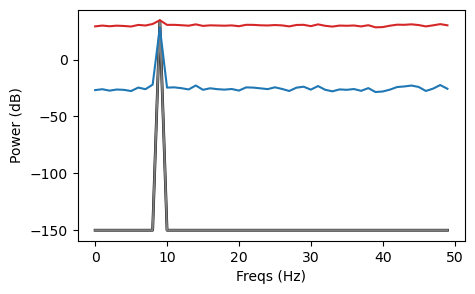

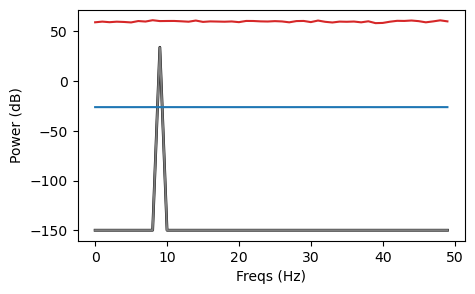

In [69]:
db = True
ov2 = -3
fshow = freqs <= 50
for ov2 in [-5, -3, 0, 3]:
    fig,ax = plt.subplots(figsize=(5,3))
    plot_result_allfreqs(ax, res_fit50[ov2], res_single[ov2], db=db, fshow=fshow, leg=False)
    ax.set_xlabel('Freqs (Hz)')
    if db is True:
        ax.set_ylabel('Power (dB)')
    else:
        ax.set_ylabel('Power')

In [55]:
ovs = [-5, -3, 0, 3]

10
50
100
1000


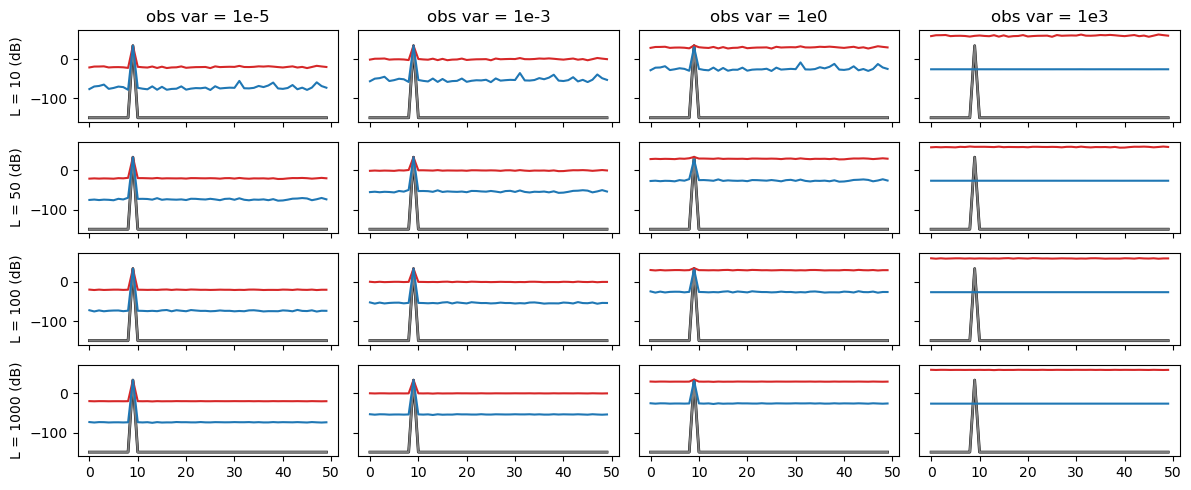

In [72]:
init = 'true-init'
# emiters = '20'
dB = True
fig, ax = plt.subplots(4,4,figsize=(12,5),sharex=True, sharey=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
Ls = [10,50,100,1000]
for i, L in enumerate(Ls):
    supp = [0, 50]
    res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    supp = None
    res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    print(L)
    # print(res_fit50.keys())
    for j, ov2 in enumerate(ovs):
        plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
        if dB is False:
            ax[i,0].set_ylabel(f'L = {L}')
        else:
            ax[i,0].set_ylabel(f'L = {L} (dB)')
        ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
50
100
1000


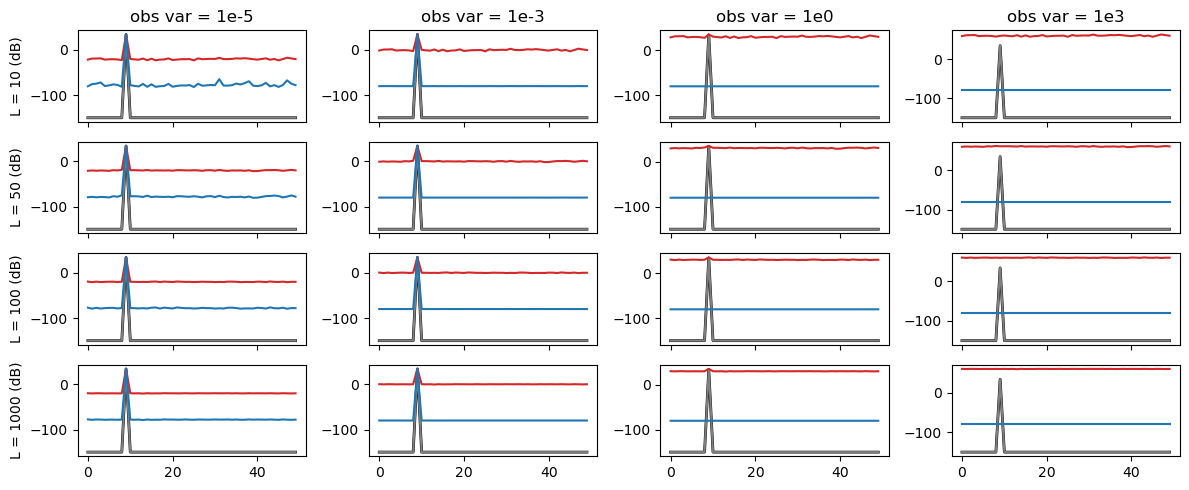

In [ ]:
init = 'flat-init'
# emiters = '20'
dB = True
fig, ax = plt.subplots(4,4,figsize=(12,5),sharex=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
Ls = [10,50,100,1000]
for i, L in enumerate(Ls):
    supp = [0, 50]
    res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    supp = None
    res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    print(L)
    # print(res_fit50.keys())
    for j, ov2 in enumerate(ovs):
        plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
        if dB is False:
            ax[i,0].set_ylabel(f'L = {L}')
        else:
            ax[i,0].set_ylabel(f'L = {L} (dB)')
        ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
50
100
1000


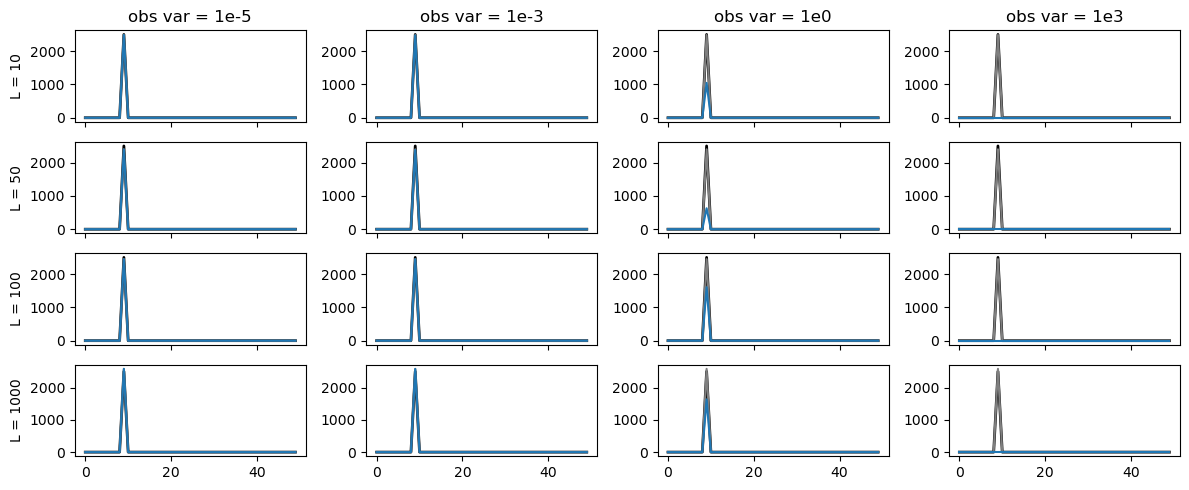

In [85]:
init = 'true-init'
# emiters = '20'
dB = False
fig, ax = plt.subplots(4,4,figsize=(12,5),sharex=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
Ls = [10,50,100,1000]
for i, L in enumerate(Ls):
    supp = [0, 50]
    res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    supp = None
    res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    print(L)
    # print(res_fit50.keys())
    for j, ov2 in enumerate(ovs):
        plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
        if dB is False:
            ax[i,0].set_ylabel(f'L = {L}')
        else:
            ax[i,0].set_ylabel(f'L = {L} (dB)')
        ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
50
100
1000


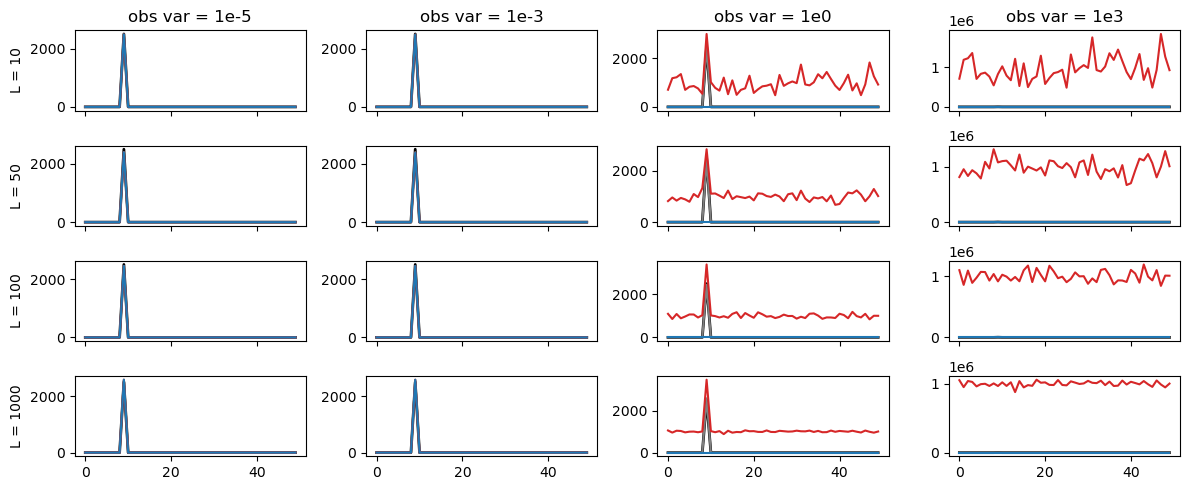

In [90]:
init = 'flat-init'
# emiters = '20'
dB = False
fig, ax = plt.subplots(4,4,figsize=(12,5),sharex=True)
# fig, ax = plt.subplots(4,4,figsize=(12,5))
# obs_vars = res_l.keys()
Ls = [10,50,100,1000]
for i, L in enumerate(Ls):
    supp = [0, 50]
    res_fit50 = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    supp = None
    res_single = load_results(res_paths, L=L, init=init, emiters=emiters, supp=supp)
    print(L)
    # print(res_fit50.keys())
    for j, ov2 in enumerate(ovs):
        plot_result_allfreqs(ax[i,j], res_fit50[ov2], res_single[ov2], db=dB, fshow=fshow)
        if dB is False:
            ax[i,0].set_ylabel(f'L = {L}')
        else:
            ax[i,0].set_ylabel(f'L = {L} (dB)')
        ax[0,j].set_title(f'obs var = 1e{ov2}')
        # ax[i,j].set_ylim([-30,50])
plt.tight_layout()


10
[[2.4836345e+03]
 [2.4742527e+03]
 [1.1457424e+03]
 [2.4517105e+00]]
50
[[2396.9158  ]
 [2377.5095  ]
 [ 889.6229  ]
 [   2.456655]]
100
[[2447.9285  ]
 [2448.3994  ]
 [1628.4907  ]
 [   2.453137]]
1000
[[2.5794004e+03]
 [2.5764368e+03]
 [1.6694603e+03]
 [2.4542716e+00]]


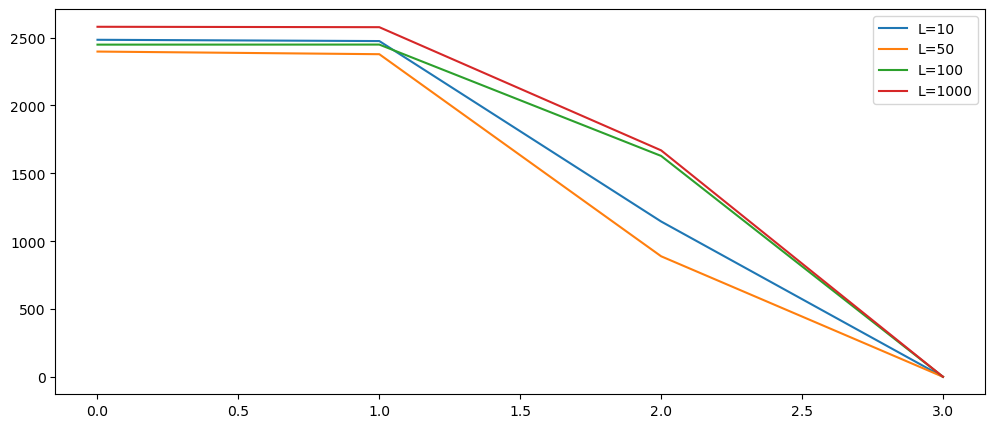

In [250]:
tind = nz
dB = False
fig, ax = plt.subplots(figsize=(12,5))
# obs_vars = res_l.keys()
S_true = gamma_full[tind,0,0].real
for i, L in enumerate(Ls):
    print(L)
    res_l = load_results(L, 'true-init')
    S_ests = []
    for j, ov in enumerate(ovs):
        gamma_est = res_l[ov]['gamma']
        gamma_est_full = jnp.zeros_like((gamma_full))
        gamma_est_full = gamma_est_full.at[nz,:,:].set(gamma_est)
        S_est = gamma_est_full[tind,0,0].real
        S_ests.append(S_est)
    S_ests = jnp.array(S_ests)
    if dB is False:
        ax.plot(S_ests, label=f'L={L}')
    else:
        ax.plot(10*jnp.log10(S_ests.real), label=f'L={L}')
    print(S_ests.real)
    ax.legend()
    
    #     if dB is False:
    #         ax[i,j].plot(S_true, 'k')
    #         ax[i,j].plot(S_est)
    #     else:
    #         ax[i,j].plot(10*jnp.log10(S_true+1e-15), 'k')
    #         ax[i,j].plot(10*jnp.log10(S_est+1e-15))
    #     ax[0,j].set_title(f'obs var = 1e{ov}')
    #     ax[i,0].set_ylabel(f'L = {L}')
    #     # ax[i,j].set_ylim([-30,50])
    # plt.tight_layout()


In [200]:
# next - check flat init on low variance and then run
# after that - add low-var up to 50 hz
gamma_path = os.path.join(gamma_root(), f"{lcfg.gamma}.pickle")
gamma_load = pickle_open(gamma_path)

gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']

gamma_full *= lcfg.scale

lrk = jr.key(lcfg.seed)
zs = sample_from_gamma(lrk, gamma_full, lcfg.L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

ork = jr.key(ocfg.seed)
obs_var = ocfg.ov1 * 10**ocfg.ov2
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

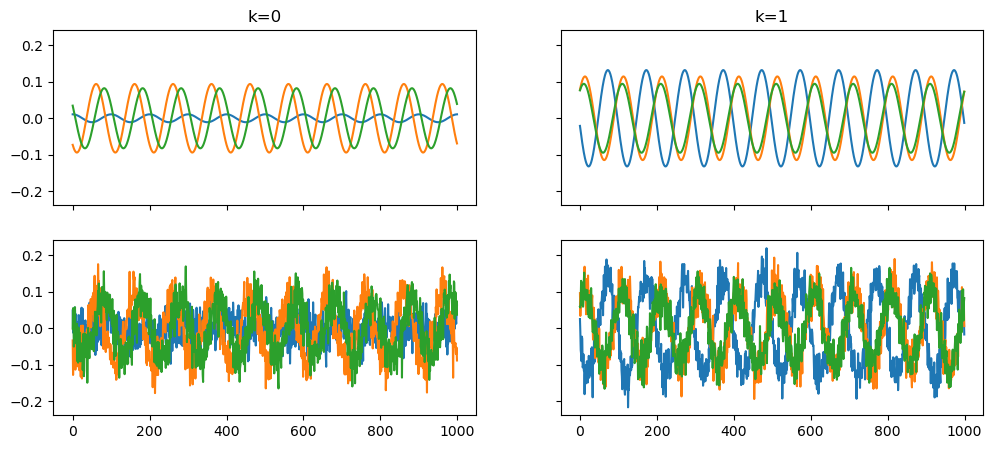

In [49]:
lig, ax = plt.subplots(2,2,figsize=(12,5), sharex=True, sharey=True)
for l in range(3):
    for k in range(2):
        ax[0,k].plot(xs[:,k,l])
        ax[1,k].plot(obs[:,k,l])
        if l == 0:
            ax[0,k].set_title(f'k={k}')
            ax[0,0].set_ylabel('')